In [1]:
# split train and test set of math symbols
import json
import random
import os

random.seed(777)

symbol_images_dir = 'symbol_images/'
terminals = ['+', '-', 'times', 'div', '!'] + list(map(str, list(range(10))))
sym_train_set = {}
sym_val_set = {}
sym_test_set = {}
for tok in terminals:
    imgs = os.listdir(symbol_images_dir + tok)
    random.shuffle(imgs)
    n_train = int(len(imgs) * 0.75)
    n_val = int(len(imgs) * 0.05)
    sym_train_set[tok] = sorted(imgs[:n_train])
    sym_val_set[tok] = sorted(imgs[n_train:n_train+n_val])
    sym_test_set[tok] = sorted(imgs[n_train+n_val:])
    print(tok, len(imgs))
json.dump(sym_train_set, open('sym_train.json', 'w'))
json.dump(sym_val_set, open('sym_val.json', 'w'))
json.dump(sym_test_set, open('sym_test.json', 'w'))

+ 25112
- 33997
times 3251
div 868
! 1300
0 6914
1 26520
2 26141
3 10909
4 7396
5 3545
6 3118
7 2909
8 3068
9 3737


In [2]:
from domain import SYM2PROG
import sys
sys.path.insert(0, "..")
sys.path.insert(0, "../semantics/dreamcoder")

from jointer import AST
import os
import random
from PIL import Image
import json
random.seed(777)

class Iterator:
    def __init__(self, l, shuffle=True):
        if shuffle: 
            random.shuffle(l)
        self.list = l
        self.current = -1
        self.shuffle = shuffle
    
    def next(self):
        self.current += 1
        if self.current == len(self.list):
            self.current = 0
            if self.shuffle:
                random.shuffle(self.list)
        return self.list[self.current]

splits = ['train', 'val', 'test']
split2sym = {}
for split in splits:
    sym_set = {k:Iterator(v) for k,v in json.load(open('sym_%s.json'%split)).items()}
    split2sym[split] = sym_set
    

def render_img(img_paths):
    images = [Image.open(symbol_images_dir + x) for x in img_paths]
    widths, heights = zip(*(i.size for i in images))

    total_width = sum(widths)
    max_height = max(heights)

    new_im = Image.new('RGB', (total_width, max_height))

    x_offset = 0
    for im in images:
        new_im.paste(im, (x_offset,0))
        x_offset += im.size[0]
    return new_im

def generate_img_paths(tokens, sym_set):
    img_paths = []
    for tok in tokens:
        if tok == '*': tok = 'times'
        if tok == '/': tok = 'div'
        
        img_name = sym_set[tok].next()
        img_paths.append(os.path.join(tok, img_name))   
        
    return img_paths

In [3]:
min_num = 0
max_num = 10
num_list = list(map(str, range(min_num, max_num)))
nonzero_num_list = [x for x in num_list if x != '0']
op_list = ['+', '-', '*', '/']

print(num_list)
print(op_list)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
['+', '-', '*', '/']


In [4]:
def enumerate_expression(n_op):
    expressions = [[x] for x in num_list]
    for _ in range(n_op):
        new = []
        for expr in expressions:
            for op in op_list:
                if op == '!':
                    new.append(expr + [op])
                else:
                    for num in num_list:
                        new.append(expr + [op, num])
        expressions = new
    expressions = ["".join(expr) for expr in expressions]
    return expressions

def sample_expression(n_op, n_instances):
    def sample():
        expr = [random.choice(num_list)]
        for _ in range(n_op):
            selected_op = random.choice(op_list)
            expr.append(selected_op)
            if selected_op == '!':
                continue
            else:
                selected_num = random.choice(num_list)
                expr.append(selected_num)
        return "".join(expr)
    
    expressions = set()
    while len(expressions) < n_instances:
        expressions.add(sample())
    return list(expressions)

def generate_expression(n_op, n_instances=None):
    if n_op <= 2:
        expressions = enumerate_expression(n_op)
    else:
        assert n_instances is not None
        expressions = sample_expression(n_op, n_instances)
    random.shuffle(expressions)
    return expressions
    
def eval_expr(expr, head):
    ast = AST(expr, head, SYM2PROG)
    return ast.res(), ast.res_all()
    
def eval_expr_by_eval(expr):
    expr_for_eval = []
    for symbol in expr:
        if symbol == '!':
            expr_for_eval[-1] = 'math.factorial(' + expr_for_eval[-1] + ')'
        elif symbol == '/':
            expr_for_eval.append('//')
        else:
            expr_for_eval.append(symbol)
#     try:
#         res = eval("".join(expr_for_eval))
#     except OverflowError:
#         res = None
    res = eval("".join(expr_for_eval))
    return res

def parse_expr(expr):
    values = []
    operators = []
    priority = {'+': 0, '-': 0, '*': 1, '/': 1, '!': 2}
    arity = {'+': 2, '-': 2, '*': 2, '/': 2, '!': 1}

    head = [-1] * len(expr)
    for (i,sym) in enumerate(expr):
        if sym.isdigit():
            values.append(i)
        else:
            while len(operators) > 0 and priority[expr[operators[-1]]] >= priority[sym]:
                op = operators.pop()
                for _ in range(arity[expr[op]]):
                    head[values.pop()] = op
                values.append(op)
            operators.append(i)

    while len(operators) > 0:
        op = operators.pop()
        for _ in range(arity[expr[op]]):
            head[values.pop()] = op
        values.append(op)

    
    root_op = values.pop()
    head[root_op] = -1
    assert len(values) == 0

    return head

expr = '6/4+2!'
head = parse_expr(expr)
res = eval_expr(expr, head)
print(expr, res, head)

6/4+2! (4, [6, 2, 4, 4, 2, 2]) [1, 3, 1, -1, 5, 3]


In [5]:
expressions = generate_expression(2)
expressions = [(x, parse_expr(x)) for x in expressions]
expressions = [(expr, head, *eval_expr(expr, head)) for expr, head in expressions]
print(len(expressions))
print(len([x for x in expressions if x[2] != 0]))
print(len([x for x in expressions if x[2] == 0]))

16000
12107
3893


In [6]:
random.seed(12306)
max_op = 10
max_train_op = 5
max_train = int(1e3)
train_exprs = []
val_exprs = []
test_exprs = []
for n_op in range(max_op + 1):
    expressions = generate_expression(n_op, 2 * max_train)
    print(n_op, len(expressions))
    expressions = [(x, parse_expr(x)) for x in expressions]
    expressions = [(expr, head, *eval_expr(expr, head)) for expr, head in expressions]
    if n_op <= max_train_op:
        train_exprs.append(expressions[:max_train])
    val_exprs.append(expressions[:2 * max_train])
    test_exprs.append(expressions[:2 * max_train])
    
split2exprs = {'train': train_exprs, 'val': val_exprs, 'test': test_exprs}
print([(k, sum([len(x) for x in v])) for k, v in split2exprs.items()])

0 10
1 400
2 16000
3 2000
4 2000
5 2000
6 2000
7 2000
8 2000
9 2000
10 2000
[('train', 4410), ('val', 18410), ('test', 18410)]


In [7]:
split = 'train'
dataset = split2exprs[split][3]
print(len(dataset))
print(dataset[:5])

1000
[('2+7*3/4', [1, -1, 3, 5, 3, 1, 5], 8, [2, 8, 7, 21, 3, 6, 4]), ('0/9/2/6', [1, 3, 1, 5, 3, -1, 5], 0, [0, 0, 9, 0, 2, 0, 6]), ('9*9-2-0', [1, 3, 1, 5, 3, -1, 5], 79, [9, 81, 9, 79, 2, 79, 0]), ('6-2-1-2', [1, 3, 1, 5, 3, -1, 5], 1, [6, 4, 2, 3, 1, 1, 2]), ('0/1*3/6', [1, 3, 1, 5, 3, -1, 5], 0, [0, 0, 1, 0, 3, 0, 6])]


In [8]:
import math

max_value_train = 100
max_value_test = 1000
split2dataset = {}
for split in splits:
    max_value = max_value_train if split == 'train' else max_value_test
    sym_set = split2sym[split]
    exprs = split2exprs[split]
    dataset = []
    idx = 0
    for n_op, expr_list in enumerate(exprs):
        n_instance = 10 if n_op > 0 else 100
        if split == 'val':
            n_instance *= 0.1
        for e in expr_list:
            if e[2] is None or max(e[3]) > max_value: continue
            for _ in range(int(math.ceil(n_instance))):
                img_paths = generate_img_paths(e[0], sym_set)
                sample = {'id': '%s_%08d'%(split, idx), 'img_paths':img_paths, 
                      'expr': e[0], 'head': e[1], 'res': e[2], 'res_all': e[3]}
                idx += 1
                dataset.append(sample)
    split2dataset[split] = dataset
    print(split, len(dataset))

train 39390
val 15811
test 158110


In [9]:
from collections import Counter

dataset = split2dataset['train']
print(len([0 for x in dataset if x['res'] != 0]))
res_counts = Counter([x['res'] for x in dataset])
print(sorted(list(res_counts.items())))
print(random.sample(dataset, k=3))

dataset = split2dataset['val']
print(len([0 for x in dataset if x['res'] != 0]))
res_counts = Counter([x['res'] for x in dataset])
print(sorted(list(res_counts.items())))
print(random.sample(dataset, k=3))

29000
[(0, 10390), (1, 3270), (2, 2140), (3, 1740), (4, 1830), (5, 1540), (6, 1600), (7, 1540), (8, 1740), (9, 1560), (10, 920), (11, 850), (12, 740), (13, 670), (14, 670), (15, 510), (16, 430), (17, 300), (18, 560), (19, 350), (20, 340), (21, 350), (22, 210), (23, 240), (24, 300), (25, 180), (26, 170), (27, 160), (28, 160), (29, 150), (30, 160), (31, 70), (32, 150), (33, 90), (34, 70), (35, 110), (36, 170), (37, 70), (38, 70), (39, 90), (40, 230), (41, 50), (42, 170), (43, 50), (44, 60), (45, 100), (46, 70), (47, 60), (48, 110), (49, 70), (50, 70), (51, 70), (52, 30), (53, 40), (54, 110), (55, 60), (56, 190), (57, 40), (58, 70), (59, 40), (60, 20), (61, 30), (62, 40), (63, 90), (64, 50), (65, 70), (66, 20), (68, 10), (69, 60), (70, 50), (71, 30), (72, 110), (73, 30), (74, 40), (77, 40), (78, 10), (79, 40), (80, 10), (81, 40), (82, 30), (83, 20), (84, 20), (85, 10), (86, 30), (87, 30), (89, 20), (90, 30), (92, 10), (93, 10), (94, 10), (95, 10), (96, 10), (99, 10)]
[{'id': 'train_000009

train 39390 99
4+9+6 [1, 3, 1, -1, 3] 19


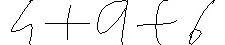

1-3*2 [1, -1, 3, 1, 3] 0


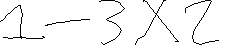

3/1*8 [1, 3, 1, -1, 3] 24


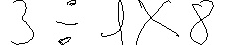

7/5/3+3 [1, 3, 1, 5, 3, -1, 5] 4


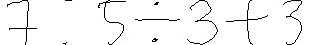

6/8-9/7-8 [1, 3, 1, 7, 5, 3, 5, -1, 7] 0


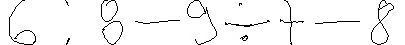

val 15811 974
0-5-0-3/5/8/7/9*0+4 [1, 3, 1, 5, 3, 17, 7, 9, 7, 11, 9, 13, 11, 15, 13, 5, 15, -1, 17] 4


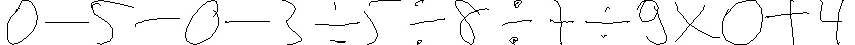

3*1-6/9 [1, 3, 1, -1, 5, 3, 5] 2


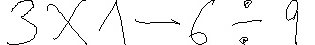

5*0*4/3+5-4+6*9-1/7/2 [1, 3, 1, 5, 3, 7, 5, 9, 7, 11, 9, 15, 13, 11, 13, -1, 17, 19, 17, 15, 19] 54


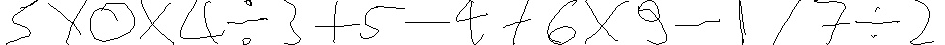

3*3/6+7/7/9 [1, 3, 1, 5, 3, -1, 7, 9, 7, 5, 9] 3


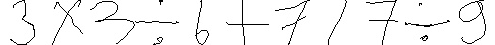

6*2-8/3 [1, 3, 1, -1, 5, 3, 5] 9


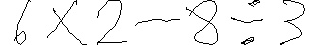

test 158110 974
3+2/7-5 [1, 5, 3, 1, 3, -1, 5] 0


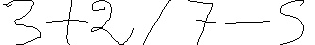

1+1-3-3*0*6+5+9+4 [1, 3, 1, 5, 3, 11, 7, 9, 7, 5, 9, 13, 11, 15, 13, -1, 15] 18


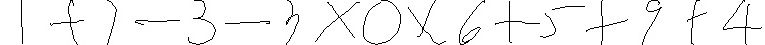

3*2-2 [1, 3, 1, -1, 3] 4


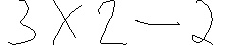

4+1+4*1/3/6/3-1 [1, 3, 1, 13, 5, 7, 5, 9, 7, 11, 9, 3, 11, -1, 13] 5


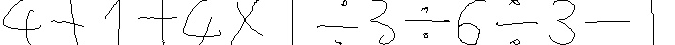

8/8+1-3*8*9+3/2*1 [1, 3, 1, 5, 3, 11, 7, 9, 7, 5, 9, -1, 13, 15, 13, 11, 15] 2


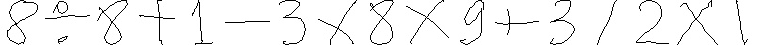

In [10]:
# Visualize data
import numpy as np
for split in splits:
    dataset = split2dataset[split]
    print(split, len(dataset), np.max([x['res'] for x in dataset]))
    for _ in range(5):
        sample = random.choice(dataset)
        img_paths = sample['img_paths']
        img = render_img(img_paths)
        print("".join(sample['expr']), sample['head'], sample['res'])
        display(img)

In [11]:
train_exprs = {x['expr'] for x in split2dataset['train']}
max_len_train = max([len(x) for x in train_exprs])
for split in ['val', 'test']:
    dataset = split2dataset[split]
    for sample in dataset:
        expr = sample['expr']
        if expr in train_exprs:
            evaluation = 1
        elif len(expr) <= max_len_train:
            max_value = max(sample['res_all'])
            if max_value <= max_value_train:
                evaluation = 2
            else:
                evaluation = 3
        else:
            max_value = max(sample['res_all'])
            if max_value <= max_value_train:
                evaluation = 4
            else:
                evaluation = 5
        sample['eval'] = evaluation

In [12]:
counts = sorted(Counter([x['eval'] for x in split2dataset['test']]).items())
total_count = sum([c for _, c in counts])
counts = [(k, round(v/total_count*100, 2)) for k, v in counts]
print(counts)
print({x['expr'] for x in split2dataset['test'] if x['eval'] == 3})

[(1, 24.91), (2, 22.05), (3, 1.87), (4, 45.38), (5, 5.78)]
{'4*6*5', '2*8*6+7-2', '1+5/3*7*1*9', '8*5*3/6*5/8', '2-7*6*5', '3*8*2*9', '4-7*9*6-1-4', '7*3*3*7', '8*7/1*4-8', '5*5*9-5+7*6', '4*7*1*8-0', '2*7*8', '4*8/2*5*7+1', '3*7*7/2+2', '4+4*6*6', '6*9*9', '7-9-7*5*6*4', '1-1-4*6*8/7', '5*5*9*4', '3*7*7*2-3*7', '7*3*9', '9*8*2-2+5-1', '5/3*7*1*8-6', '8*7+2*7*4', '7*8*9+2', '5+8*3*8*0', '4-0-6+4*5*7', '6*4*8', '5*8*4/9*7/7', '9*2*4*5+4/9', '3-7*6*5-5+7', '9*5*6', '8/1*5*8', '6*8+3*7*9', '4-9*8*3', '7+5*8*4', '1-8*2*9-3', '3+8*6*7/8-0', '1/8/4+6*7*3', '4*2*6*3', '8+6*6*3/2', '7*7/1*3-8', '3+9*7*3+1*2', '1*9*2*8', '6*7*7-5-4+0', '6+5*7*8', '1*9*2*9+0-3', '8*8*5+6-4+9', '7*3*5+4*7-9', '7*5*8/5', '3*5*9-9', '7*6*4/4-5', '1+3+5*4*9/2', '5*2*8-3*9*4', '5*6/7*6*6-4', '1/9*8*1*2*7', '8*5*2+5*4+4', '9/2/9+8*6*8', '3*6*8-1', '1+8*3*6/5', '5*4*6*3+2', '2-4+5*5*9', '1-9*4*4-3', '8+3*8*8', '4*0+8+6*9*7', '0-3-5*5*3*7', '6*7*4*0', '8-8*9*9', '6-9-5*6*7', '6*6*5/4-4', '4*8*7+7+4+0', '8*8*4', '7-2*4*4

In [13]:
for split in splits:
    json.dump(split2dataset[split], open('expr_%s.json'%split, 'w'))

(45, 45)


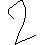

7/1/7-2 = -1.0


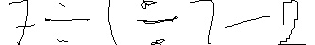

In [14]:
img = Image.open(symbol_images_dir + '2/2_849.jpg')
print(img.size)
display(img)

expr = '7/1/7-2'
img_paths = generate_img_paths(expr, sym_set=sym_set)
img = render_img(img_paths)
print(expr,'=', eval(expr))
display(img)